## Creating a Control Sample

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

plt.rcParams['font.size'] = 14

In [3]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing Data

In [4]:
df_cat = pd.read_csv(f'{combine_fold}/primary-secondary-z-checked.csv', index_col = 0)

In [5]:
with fits.open(f'{cos_dat_fold}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

### Matching Creating DataFrame of Required Information

In [6]:
df_red = df_cat[['ORyan23_ID_1', 'ID_Prim', 'ID_Sec', 'lp_mass_best_prim', 'lp_mass_best_sec', 'ez_sfr_prim', 'ez_sfr_sec', 'z_prim', 'z_sec', 'Prim_RA','Prim_Dec','Sec_RA','Sec_Dec']]

In [8]:
df_red

,ORyan23_ID_1,ID_Prim,ID_Sec,lp_mass_best_prim,lp_mass_best_sec,ez_sfr_prim,ez_sfr_sec,z_prim,z_sec,Prim_RA,Prim_Dec,Sec_RA,Sec_Dec
0,4000705540519,1324784,1324712,8.57956,8.85961,-0.783763,-0.291023,0.303057,0.283853,149.699231,2.679556,149.696134,2.679032
1,4000705547180,1266054,1264241,10.60467,10.53484,0.997192,1.474177,0.995600,0.982027,150.320392,2.620598,150.319695,2.618060
2,4000706649921,840582,844303,10.84630,11.05237,1.745799,2.547000,1.152400,1.118725,150.061821,2.218277,150.059115,2.219933
3,4000707046655,214433,219965,6.70360,9.38022,-1.890665,0.243848,0.217500,0.198500,150.227153,1.617348,150.224865,1.618780
4,4000707047768,246358,246327,10.63540,10.53981,0.144319,0.066335,0.227065,0.204897,150.200064,1.632469,150.197217,1.631803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4000854480186,917157,917450,10.18464,9.86348,0.229133,0.465022,0.611400,0.621800,150.044314,2.288238,150.043229,2.289116
496,4000858402222,1450508,1449463,8.00974,8.12319,-1.172457,-1.228323,0.135300,0.137034,150.310093,2.801374,150.309534,2.800553
497,4000859156914,793415,791176,10.39720,10.65839,0.951088,0.340505,0.593900,0.545800,149.653540,2.173049,149.654031,2.172352
498,4000859744431,1395467,1395057,10.03151,9.95693,1.226215,1.176297,0.921772,0.923286,150.234052,2.746578,150.235280,2.746598


In [11]:
df_prim = (
    df_red
    [['ORyan23_ID_1', 'ID_Prim', 'lp_mass_best_prim', 'ez_sfr_prim', 'z_prim', 'Prim_RA','Prim_Dec']]
    .rename(columns = {'ORyan23_ID_1':'ORyan_ID','ID_Prim':'ID','lp_mass_best_prim':'lp_mass_best','z_prim':'z', 'ez_sfr_prim' : 'ez_sfr'})
    .set_index('ORyan_ID')
)

df_sec = (
    df_red
    [['ORyan23_ID_1', 'ID_Sec', 'lp_mass_best_sec', 'ez_sfr_sec', 'z_sec', 'Sec_RA','Sec_Dec']]
    .rename(columns = {'ORyan23_ID_1':'ORyan_ID','ID_Sec':'ID','lp_mass_best_sec':'lp_mass_best','z_sec':'z', 'ez_sfr_sec' : 'ez_sfr'})
    .set_index('ORyan_ID')
)

In [12]:
df_all = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
known_ids = list(df_all['ID'])

## Creating Control Sample for Primary

In [14]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [15]:
def find_controls(id_str, lp_mass, ra, dec, z, cat_ids, control_ids, data):
    data_red = data[(data['lp_mass_best'] >= lp_mass - 0.01) & (data['lp_mass_best'] <= lp_mass + 0.01)]
    
    data_df = (Table(data_red)).to_pandas()
    
    data_red = data_df[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    data_z = (
        data_red
        .assign(redshift = data_red.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
    )
    
    data_dna = data_z.dropna()
    
    min_z = z - 0.01
    max_z = z + 0.01
    data_z_red = data_dna.query('redshift >= @min_z and redshift <= @max_z')
        
    for i in range(len(data_z_red)):
        id_control = data_z_red.ID.iloc[i]
        if id_control not in cat_ids and id_control not in control_ids:
            return id_control
        else:
            continue
    
    return np.nan

In [16]:
prim_dict = df_prim.to_dict(orient = 'index')

In [17]:
control_sample = {}
control_ids = []

In [18]:
done_ids = list(control_sample.keys())
for i in tqdm(list(prim_dict.keys())):
    if i in done_ids:
        continue
    
    control_sample[i] = find_controls(prim_dict[i]['ID'], prim_dict[i]['lp_mass_best'], prim_dict[i]['Prim_RA'], prim_dict[i]['Prim_Dec'], prim_dict[i]['z'], known_ids, control_ids, data)
    control_ids.append(control_sample[i])

100%|██████████| 480/480 [14:28<00:00,  1.81s/it]


In [19]:
df_prim_control = pd.DataFrame.from_dict(control_sample, orient = 'index').reset_index().rename(columns = {'index':'ORyan_ID', 0 : 'control_ID'})
df_prim_control

,ORyan_ID,control_ID
0,4000705540519,1407.0
1,4000705547180,11607.0
2,4000706649921,78056.0
3,4000707046655,144765.0
4,4000707047768,26947.0
...,...,...
475,4000854480186,254046.0
476,4000858402222,52157.0
477,4000859156914,3308.0
478,4000859744431,1655.0


In [20]:
df_prim

,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec
ORyan_ID,,,,,,
4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556
4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598
4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277
4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348
4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469
...,...,...,...,...,...,...
4000854480186,917157,10.18464,0.229133,0.611400,150.044314,2.288238
4000858402222,1450508,8.00974,-1.172457,0.135300,150.310093,2.801374
4000859156914,793415,10.39720,0.951088,0.593900,149.653540,2.173049


In [21]:
df_prim_all = df_prim.reset_index().merge(df_prim_control, on = 'ORyan_ID', how = 'left')
len(df_prim_all)

480

## Creating Control Sample for Secondary

In [22]:
sec_dict = df_sec.to_dict(orient = 'index')

In [23]:
control_sample = {}

In [24]:
done_ids = list(control_sample.keys())
for i in tqdm(list(sec_dict.keys())):
    if i in done_ids:
        continue
    
    control_sample[i] = find_controls(sec_dict[i]['ID'], sec_dict[i]['lp_mass_best'], sec_dict[i]['Sec_RA'], sec_dict[i]['Sec_Dec'], sec_dict[i]['z'], known_ids, control_ids, data)
    control_ids.append(control_sample[i])

100%|██████████| 480/480 [15:00<00:00,  1.88s/it]


In [25]:
df_sec_control = pd.DataFrame.from_dict(control_sample, orient = 'index').reset_index().rename(columns = {'index':'ORyan_ID', 0 : 'control_ID'})

In [26]:
df_sec_all = df_sec.merge(df_sec_control, on = 'ORyan_ID', how = 'left')

In [27]:
df_sec_all

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Sec_RA,Sec_Dec,control_ID
0,4000705540519,1324712,8.85961,-0.291023,0.283853,149.696134,2.679032,3855.0
1,4000705547180,1264241,10.53484,1.474177,0.982027,150.319695,2.618060,44969.0
2,4000706649921,844303,11.05237,2.547000,1.118725,150.059115,2.219933,25129.0
3,4000707046655,219965,9.38022,0.243848,0.198500,150.224865,1.618780,242.0
4,4000707047768,246327,10.53981,0.066335,0.204897,150.197217,1.631803,178132.0
...,...,...,...,...,...,...,...,...
475,4000854480186,917450,9.86348,0.465022,0.621800,150.043229,2.289116,24398.0
476,4000858402222,1449463,8.12319,-1.228323,0.137034,150.309534,2.800553,52844.0
477,4000859156914,791176,10.65839,0.340505,0.545800,149.654031,2.172352,29016.0
478,4000859744431,1395057,9.95693,1.176297,0.923286,150.235280,2.746598,57944.0


## Conducting Checks

In [28]:
df_prim_all.head()

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec,control_ID
0,4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556,1407.0
1,4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598,11607.0
2,4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277,78056.0
3,4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348,144765.0
4,4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469,26947.0


In [29]:
df_sec_all.head()

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Sec_RA,Sec_Dec,control_ID
0,4000705540519,1324712,8.85961,-0.291023,0.283853,149.696134,2.679032,3855.0
1,4000705547180,1264241,10.53484,1.474177,0.982027,150.319695,2.618060,44969.0
2,4000706649921,844303,11.05237,2.547000,1.118725,150.059115,2.219933,25129.0
3,4000707046655,219965,9.38022,0.243848,0.198500,150.224865,1.618780,242.0
4,4000707047768,246327,10.53981,0.066335,0.204897,150.197217,1.631803,178132.0


In [30]:
prim_ids = list(df_prim_all.ID)
sec_ids = list(df_sec_all.ID)
prim_cont_ids = list(df_prim_all.control_ID)
sec_cont_ids = list(df_sec_all.control_ID)

In [31]:
for i in prim_ids:
    if i in prim_cont_ids:
        print('Primary control failed!')

In [32]:
for i in prim_ids:
    if i in sec_cont_ids:
        print('Moving from Primary to Secondary control failed!')

In [33]:
for i in prim_ids:
    if i in sec_ids:
        print('Might as well check there\'s no primary or secondary overlap.')

In [34]:
for i in sec_ids:
    if i in prim_cont_ids:
        print('Secondaries used in primary control!')

In [35]:
for i in sec_ids:
    if i in sec_cont_ids:
        print('Duplication in secondary control!')

## Checking Distributions

In [36]:
def get_control_mass(ID, data):
    if np.isnan(ID):
        return np.nan
    row = data[data['ID'] == ID]
    return row['lp_mass_best'][0]

In [37]:
df_prim_control_mass = (
    df_prim_all
    .assign(lp_mass_cont = df_prim_all.control_ID.progress_apply(lambda x: get_control_mass(x, data)))
)

100%|██████████| 480/480 [05:14<00:00,  1.53it/s]


In [38]:
df_sec_control_mass = (
    df_sec_all
    .assign(lp_mass_cont = df_sec_all.control_ID.progress_apply(lambda x: get_control_mass(x, data)))
)

100%|██████████| 480/480 [05:23<00:00,  1.49it/s]


In [39]:
df_comb_tmp = pd.concat([df_prim_control_mass, df_sec_control_mass])

In [40]:
df_comb_tmp

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec,control_ID,lp_mass_cont,Sec_RA,Sec_Dec
0,4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556,1407.0,8.57518,NaN,NaN
1,4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598,11607.0,10.60752,NaN,NaN
2,4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277,78056.0,10.84728,NaN,NaN
3,4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348,144765.0,6.70853,NaN,NaN
4,4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469,26947.0,10.63477,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
475,4000854480186,917450,9.86348,0.465022,0.621800,NaN,NaN,24398.0,9.85508,150.043229,2.289116
476,4000858402222,1449463,8.12319,-1.228323,0.137034,NaN,NaN,52844.0,8.13026,150.309534,2.800553
477,4000859156914,791176,10.65839,0.340505,0.545800,NaN,NaN,29016.0,10.65634,149.654031,2.172352
478,4000859744431,1395057,9.95693,1.176297,0.923286,NaN,NaN,57944.0,9.96211,150.235280,2.746598


In [58]:
bins = np.linspace(6.5, 12.5, 20)

In [59]:
df_export = pd.concat([df_prim_control_mass[['lp_mass_best', 'lp_mass_cont']], df_sec_control_mass[['lp_mass_best', 'lp_mass_cont']]])

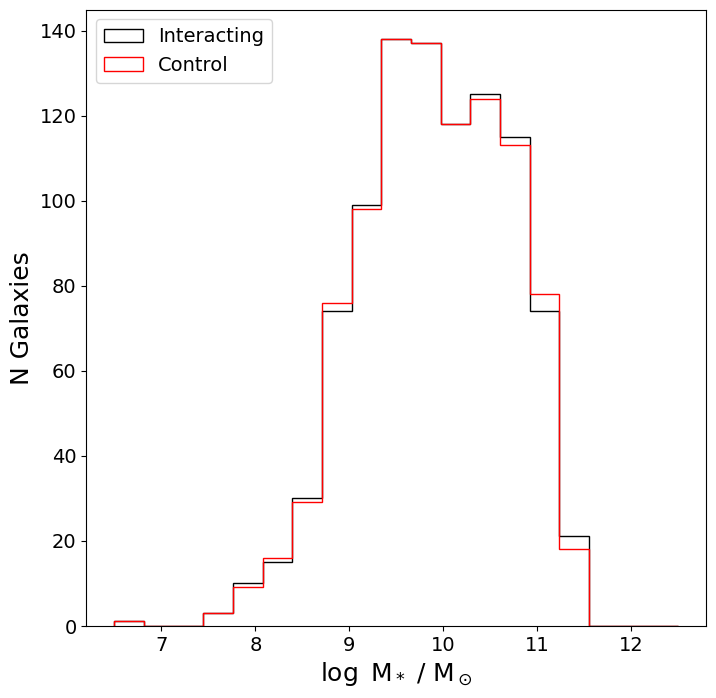

In [71]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_export.lp_mass_best), bins = bins, histtype='step', color = 'black')
ax.hist(list(df_export.lp_mass_cont), bins = bins, histtype='step', color='red')
plt.xlabel('$\log$ M$_*$ / M$_\odot$', fontsize = 18)
plt.ylabel('N Galaxies', fontsize = 18)
plt.legend(['Interacting', 'Control'], loc = 'upper left')
plt.savefig(f'{fig_folder}/mass-matching-pairs.pdf', bbox_inches='tight')
plt.show()

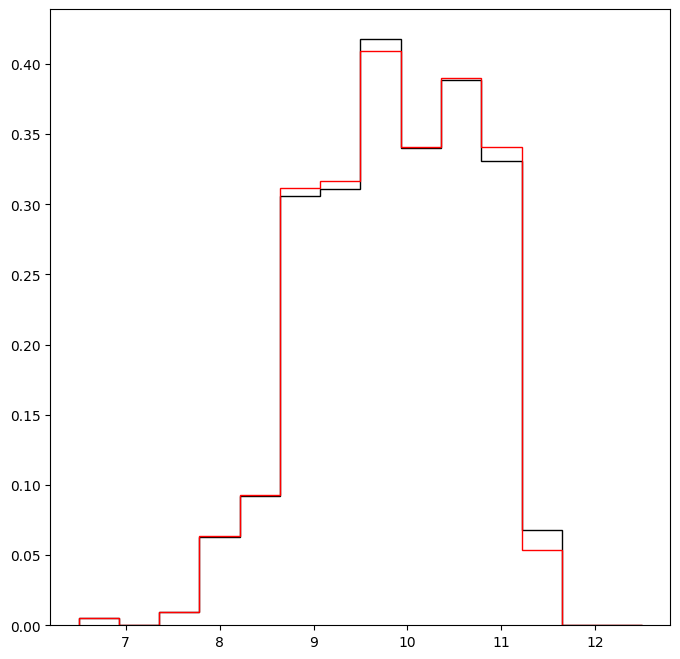

In [42]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_prim_control_mass.lp_mass_best), bins = bins, histtype='step', color = 'black', density = True)
ax.hist(list(df_prim_control_mass.lp_mass_cont), bins = bins, histtype='step', color='red', density = True)
plt.show()

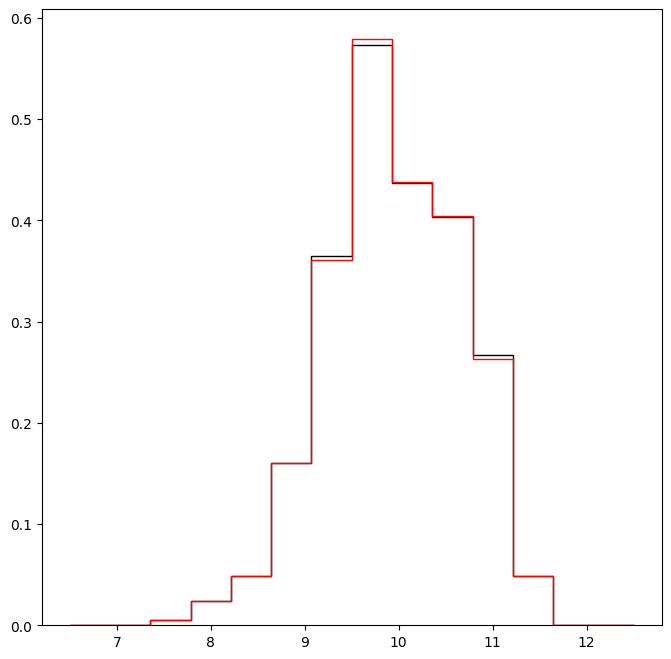

In [43]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_sec_control_mass.lp_mass_best), bins = bins, histtype='step', color = 'black', density = True)
ax.hist(list(df_sec_control_mass.lp_mass_cont), bins = bins, histtype='step', color='red', density = True)
plt.show()

## Getting SFR Distribution

In [44]:
def get_control_sfr(ID, data):
    if np.isnan(ID):
        return np.nan
    row = data[data['ID'] == ID]
    return row['ez_sfr'][0]

In [45]:
df_prim_control_sfr = (
    df_prim_control_mass
    .assign(ez_sfr_cont = df_prim_control_mass.control_ID.progress_apply(lambda x: get_control_sfr(x, data)))
)

100%|██████████| 480/480 [05:17<00:00,  1.51it/s]


In [46]:
df_sec_control_sfr = (
    df_sec_control_mass
    .assign(ez_sfr_cont = df_sec_control_mass.control_ID.progress_apply(lambda x: get_control_sfr(x, data)))
)

100%|██████████| 480/480 [05:14<00:00,  1.52it/s]


In [50]:
bins = np.linspace(-5,3.5,15)

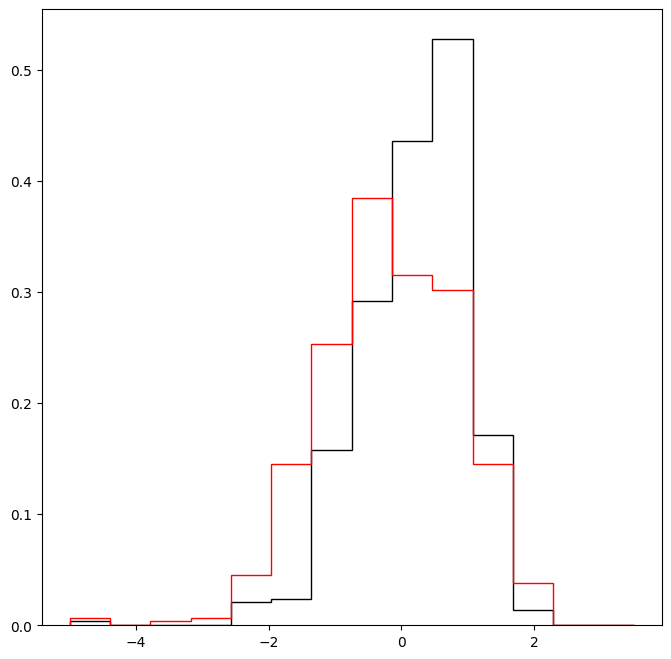

In [51]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_prim_control_sfr.ez_sfr), bins = bins, histtype='step', color = 'black', density = True)
ax.hist(list(df_prim_control_sfr.ez_sfr_cont), bins = bins, histtype='step', color='red', density = True)
plt.show()

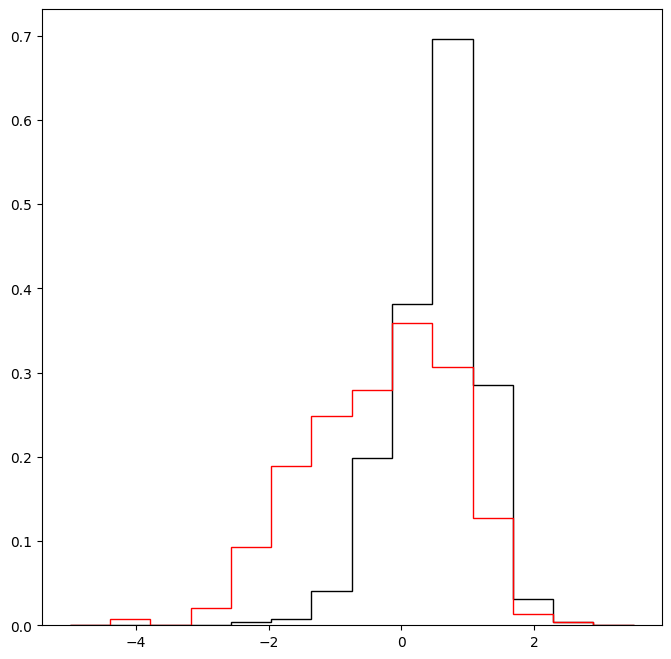

In [52]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(list(df_sec_control_sfr.ez_sfr), bins = bins, histtype='step', color = 'black', density = True)
ax.hist(list(df_sec_control_sfr.ez_sfr_cont), bins = bins, histtype='step', color='red', density = True)
plt.show()

In [72]:
df_prim_control_sfr

,ORyan_ID,ID,lp_mass_best,ez_sfr,z,Prim_RA,Prim_Dec,control_ID,lp_mass_cont,ez_sfr_cont
0,4000705540519,1324784,8.57956,-0.783763,0.303057,149.699231,2.679556,1407.0,8.57518,-0.939075
1,4000705547180,1266054,10.60467,0.997192,0.995600,150.320392,2.620598,11607.0,10.60752,1.397521
2,4000706649921,840582,10.84630,1.745799,1.152400,150.061821,2.218277,78056.0,10.84728,1.717686
3,4000707046655,214433,6.70360,-1.890665,0.217500,150.227153,1.617348,144765.0,6.70853,-1.967947
4,4000707047768,246358,10.63540,0.144319,0.227065,150.200064,1.632469,26947.0,10.63477,-0.795808
...,...,...,...,...,...,...,...,...,...,...
475,4000854480186,917157,10.18464,0.229133,0.611400,150.044314,2.288238,254046.0,10.17516,0.062293
476,4000858402222,1450508,8.00974,-1.172457,0.135300,150.310093,2.801374,52157.0,8.01636,-1.892681
477,4000859156914,793415,10.39720,0.951088,0.593900,149.653540,2.173049,3308.0,10.39488,-2.490311
478,4000859744431,1395467,10.03151,1.226215,0.921772,150.234052,2.746578,1655.0,10.02600,0.813517


In [73]:
df_prim_control_sfr.to_csv(f'{combine_fold}/primary-control-sample.csv')
df_sec_control_sfr.to_csv(f'{combine_fold}/secondary-control-sample.csv')